In [1]:
#original is masked :/

In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
!nvidia-smi

Fri Feb  8 18:56:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.77                 Driver Version: 390.77                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   36C    P2    53W / 250W |   8925MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_ssim
from math import sqrt
import numpy as np
import time, os, random
from keras.callbacks import TensorBoard
%matplotlib inline
import matplotlib.pyplot as plt
from keras.callbacks import History

from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras.layers.merge import _Merge
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import scipy
import pandas as pd
from functools import partial

import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from pprint import pprint
EXECUTION_TIME = time.strftime("%Y%m%d-%H%M%S")

Using TensorFlow backend.


In [5]:
from random import randint
import itertools
import numpy as np
import cv2


def random_mask(height, width, channels=3):
    """Generates a random irregular mask with lines, circles and elipses"""    
    img = np.zeros((height, width, channels), np.uint8)

    # Set size scale
    size = int((width + height) * 0.03)
    if width < 64 or height < 64:
        raise Exception("Width and Height of mask must be at least 64!")
    
    # Draw random lines
    for _ in range(randint(1, 20)):
        x1, x2 = randint(1, width), randint(1, width)
        y1, y2 = randint(1, height), randint(1, height)
        thickness = randint(3, size)
        cv2.line(img,(x1,y1),(x2,y2),(1,1,1),thickness)
        
    # Draw random circles
    for _ in range(randint(1, 20)):
        x1, y1 = randint(1, width), randint(1, height)
        radius = randint(3, size)
        cv2.circle(img,(x1,y1),radius,(1,1,1), -1)
        
    # Draw random ellipses
    for _ in range(randint(1, 20)):
        x1, y1 = randint(1, width), randint(1, height)
        s1, s2 = randint(1, width), randint(1, height)
        a1, a2, a3 = randint(3, 180), randint(3, 180), randint(3, 180)
        thickness = randint(3, size)
        cv2.ellipse(img, (x1,y1), (s1,s2), a1, a2, a3,(1,1,1), thickness)
        
    #img = (1-img)[:,:,0]
    return 1-img


In [7]:
#loaded = W_GP_CCGAN.load_model('experiments/20190122-144825/W_GP_CCGAN(learn_rate=0.001,_beta_1=0.9,_**config)/', 176, 144, 0.001, 0.9)

In [8]:
#loaded.generator.predict(HIGH)

In [9]:
#masks = [random_mask(176, 144, channels=1) for i in range(20)]#channels=1

In [ ]:
#mse = np.average([mean_squared_error(img_true[mask==0], img_predict[mask==0]) for img_true, img_predict, mask in zip(XX,XX, masks)])

In [6]:
def masked_area_score(model,X):
    to_be_masked = np.copy(X)
    masks = [random_mask(176, 144, channels=1) for i in range(len(X))]#channels=1
    masked_data = []
    for img, mask in zip(to_be_masked, masks):
        img[mask==0] = 0
        masked_data.append(img)
    masked_data = np.asanyarray(masked_data)
    #masked_data = np.expand_dims(masked_data, axis=3)
    predicted_data = model.generator.predict(masked_data)
    
    mse = np.average([mean_squared_error(img_true[mask==0], img_predict[mask==0]) for img_true, img_predict, mask in zip(X,predicted_data, masks)])
    ssim = np.average([compare_ssim(img_true[mask==0], img_predict[mask==0]) for img_true, img_predict, mask in zip(X,predicted_data,masks)])
    
    return mse, ssim


In [7]:
def whole_image_score(model, X):
    to_be_masked = np.copy(X)
    masks = [random_mask(176, 144, channels=1) for i in range(len(X))]#channels=1
    masked_data = []
    for img, mask in zip(to_be_masked, masks):
        img[mask==0] = 0
        masked_data.append(img)
    masked_data = np.asanyarray(masked_data)
    predicted_data = model.generator.predict(masked_data)

    mse = np.average([mean_squared_error(img_true[...,0], img_predict[...,0]) for img_true,img_predict in zip(X, predicted_data)])
    ssim = np.average([compare_ssim(img_true[...,0], img_predict[...,0]) for img_true,img_predict in zip(X, predicted_data)])
    return mse, ssim

In [8]:
def outside_area_score(model,X):
    to_be_masked = np.copy(X)
    masks = [random_mask(176, 144, channels=1) for i in range(len(X))]#channels=1
    masked_data = []
    for img, mask in zip(to_be_masked, masks):
        img[mask==0] = 0
        masked_data.append(img)
    masked_data = np.asanyarray(masked_data)
    predicted_data = model.generator.predict(masked_data)
    
    mse = np.average([mean_squared_error(img_true[mask==1], img_predict[mask==1]) for img_true, img_predict, mask in zip(X,predicted_data, masks)])
    ssim = np.average([compare_ssim(img_true[mask==1], img_predict[mask==1]) for img_true, img_predict, mask in zip(X,predicted_data,masks)])
    return mse, ssim

In [9]:
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

In [10]:
from collections import defaultdict
class W_GP_CCGAN(object):
    def __init__(self, img_rows, img_cols, learn_rate, beta_1,create_dir=True): #constructor
        self.img_rows = img_rows#176#32 176x144
        self.img_cols = img_cols #144#32 #property
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 45#10
        self.d_loss = {}
        self.g_loss = {}
        self.scores = defaultdict(dict)
        
        self.latent_dim = 100
        
        # Number of filters in first layer of generator and discriminator
        self.gf = 32
        self.df = 32
        self.learn_rate=learn_rate
        self.beta_1 = beta_1
        #optimizer = Adam(self.learn_rate, self.beta_1) #learning_rate 0.0002, adam_beat_1 0.5
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=learn_rate) ##0.00005 !!!
        
        # Build and compile the critic -> discriminator
        self.critic = self.build_critic()
        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise?!?! as input and generates imgs
        masked_img = Input(shape=self.img_shape) #Input instantiate a keras tensor
        #gen_img = self.generator(masked_img)

        # Freeze generator's layers while training critic
        self.generator.trainable = False
        
        # Image input (real sample)
        real_img = Input(shape=self.img_shape)
        # Generate image based of noise (fake sample)
        fake_img = self.generator(masked_img)

        # Discriminator determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)
        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional  # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, masked_img],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        masked_img = Input(shape=self.img_shape)
        #z_gen = Input(shape=(100,))
        # Generate images based of noise
        img = self.generator(masked_img)
        # Discriminator determines validity
        valid = self.critic(img)
        # Defines generator model
        self.generator_model = Model(masked_img, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)
        if create_dir:
            os.makedirs(self.folder_name())#, ignore_errors=True) # CHECK
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)

        
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
#################################################################################################
   
    def build_generator(self): #method
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = BatchNormalization(momentum=0.8)(u)
            u = Concatenate()([u, skip_input])
            return u

        img = Input(shape=self.img_shape)

        # Downsampling
        d1 = conv2d(img, self.gf, bn=False)
        d2 = conv2d(d1, self.gf*2)
        mid = Conv2D(64, kernel_size=4, strides=1, padding='same')(d2)
        mid_leaky = LeakyReLU(alpha=0.2)(mid)
        d3 = conv2d(mid_leaky, self.gf*8)
        d4 = conv2d(d3, self.gf*16)

        # Upsampling
        u1 = deconv2d(d4, d3, self.gf*8)
        oth = Conv2D(64, kernel_size=4,strides=1, padding='same')(u1)
        oth_leaky = BatchNormalization(momentum=0.8)(oth)
        u2 = deconv2d(oth_leaky, d2, self.gf*2)
        u3 = deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u4) #tanh
        
        return Model(img, output_img)

    def build_critic(self):

        img = Input(shape=self.img_shape)

        model = Sequential()
        model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, kernel_size=6, strides=1, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        
        #model.add(InstanceNormalization())
        model.add(BatchNormalization(momentum=0.8))
        
        model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        
        #model.add(InstanceNormalization())
        model.add(BatchNormalization(momentum=0.8))
        #added for WGAN_GP
        model.add(Flatten())
        model.add(Dense(1))
        #model.summary()

        img = Input(shape=self.img_shape)
        #features = model(img)

        #validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(features)

        #label = Flatten()(features)
        #label = Dense(self.num_classes+1, activation="softmax")(label)
        validity = model(img)

        return Model(img, validity)

        #return Model(img, [validity, label])

    def mask_randomly(self, imgs):
        masked_imgs = np.copy(imgs)
        for i, img in enumerate(masked_imgs):
            mask = random_mask(176, 144, channels=1)
            img[mask==0] = 0
            masked_imgs[i] = img
        return masked_imgs
###############################################################################

    def train(self, X_train, epochs, batch_size, sample_interval):
        
        y_train = np.ones(len(X_train))
        # Adversarial ground truths
        #valid = -np.ones((batch_size, int(self.img_rows/8), int(self.img_cols/8), 1)) #* random.uniform(0.7, 1.2)
        #fake = np.ones((batch_size, int(self.img_rows/8), int(self.img_cols/8), 1)) #* random.uniform(0, 0.3)
 
                # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake =  np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty

        
        for epoch in range(epochs):
            
            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------
                # Train the critic

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                
                # Sample generator input -> masked imgs!!!
                #noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                masked_imgs = self.mask_randomly(imgs)
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, masked_imgs],
                                                                [valid, fake, dummy])
                
                
 
            #  Train Generator
            g_loss = self.generator_model.train_on_batch(masked_imgs, valid)

        # Plot the progress    
            if epoch % (10*sample_interval) == 0:
                print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
                                
            if epoch % sample_interval == 0:
                self.scores['d_loss'][epoch] = d_loss[0]
                self.scores['g_loss'][epoch] = g_loss
            if epoch % (10*sample_interval) == 0:
                own_scores = self.evaluate(self.scorers)
                for key,value in own_scores.items():
                    self.scores[key][epoch]=value

            
            # If at save interval => save generated image samples
#            if epoch % (20*sample_interval) == 0:
#                self.sample_images(epoch)
                # Select a random half batch of images

    
    
    def sample_images(self, imgs, folder_name):
        r, c = 3, 6

        masked_imgs = self.mask_randomly(imgs)
        gen_imgs = self.generator.predict(masked_imgs)

        imgs = (imgs + 1.0) * 0.5
        masked_imgs = (masked_imgs + 1.0) * 0.5
        gen_imgs = (gen_imgs + 1.0) * 0.5

        gen_imgs = np.where(gen_imgs < 0, 0, gen_imgs)

        fig, axs = plt.subplots(r, c)
        for i in range(c):
            axs[0,i].imshow(imgs[i, :, :, 0], cmap='gray')
            axs[0,i].axis('off')
            axs[1,i].imshow(masked_imgs[i, :, :, 0], cmap='gray')
            axs[1,i].axis('off')
            axs[2,i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
            axs[2,i].axis('off')
        try:
            fig.savefig("{}/final.png".format(folder_name))
        except Exception as e:
            print("Couldn't save images because of {e}".format(e=e))
        finally:
            plt.close()

    def save_model(self,folder_name):

        def save(model, model_name):
            model_path = "{}/{}.json".format(folder_name, model_name)
            weights_path = "{}/{}_weights.hdf5".format(folder_name, model_name)
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "ccgan_generator")
        save(self.critic, "ccgan_discriminator")
    @staticmethod
    def load_model(folder_name,img_rows,img_cols,learn_rate,beta_1 ):
        from keras.models import model_from_json
        discriminator = model_from_json(open("{}/ccgan_discriminator.json".format(folder_name)).read())
        discriminator.load_weights("{}/ccgan_discriminator_weights.hdf5".format(folder_name))
        generator = model_from_json(open("{}/ccgan_generator.json".format(folder_name)).read())
        generator.load_weights("{}/ccgan_generator_weights.hdf5".format(folder_name))
        #c = W_GP_CCGAN()
        c = W_GP_CCGAN(img_rows, img_cols, learn_rate, beta_1,False)
        c.discriminator = discriminator
        c.generator = generator
        return c
    def save_losses(self):
        for key in self.scores:
            pd.Series(self.scores[key]).to_csv('{}/{}.csv'.format(self.folder_name(),key))
        
    # Model has .train,.sample_images,.save_model
    def train_this(self, X_low_dim, epochs):
        X = np.expand_dims(X_low_dim, axis=3)
        X_train, X_test = train_test_split(X)
        self.X_test_ = X_test
        start_time = time.clock()
        self.train(X_train,epochs,batch_size=32, sample_interval=1)
        idx = np.random.randint(0, X_train.shape[0], 6)
        imgs = X_train[idx]
        self.sample_images(imgs,self.folder_name())
        self.save_model(self.folder_name())
        print(time.clock() - start_time, "seconds")
    
    def evaluate(self, scorers):
        score = {scorer.__name__ : scorer(self, self.X_test_) for scorer in scorers}
        return score
        
    
    def folder_name(self):
        model_name = str(self).replace(' ','_')
        return 'experiments/{}/{}'.format(EXECUTION_TIME,model_name)
    
    def __repr__(self):
        return "{}(learn_rate={}, beta_1={}, **config)".format(self.__class__.__name__,self.learn_rate,self.beta_1)

In [11]:
#paths = ['slike/affine_data_standardize_change_range_x_train.npy', 'slike/affine_data_normalize_change_range_x_train.npy',
#         'slike/affine_data_normalize_standardize_change_range_x_train.npy', 'slike/affine_data_standardize_normalize_change_range_x_train.npy']
#X_train = list((path,np.load(path)) for path in paths)[0][1]
X_train = np.load('data/slike/healthy-axis2-affine_transf_x_train.npy')

In [ ]:
#X_train = np.random.rand(3,176,144)
epochs= 10000
scorers= [masked_area_score, outside_area_score, whole_image_score]
config = dict(img_rows=np.shape(X_train)[1], img_cols=np.shape(X_train)[2])

betas = [0.9]
learning_rates = [0.0001]

models =[W_GP_CCGAN(beta_1=beta, learn_rate=learning_rate, **config) for beta in betas for learning_rate in learning_rates]
#models.append(SoftLabelGAN(beta_1=0.9,learn_rate=0.0001,**config))
#models.append(DropoutGAN(beta_1=0.9,learn_rate=0.0001,**config))
#models.append(SoftandDrop(beta_1=0.9,learn_rate=0.0001,**config))
for model in models:
    model.scorers = scorers
results = {model:model.train_this(X_train, epochs=epochs) for model in models}

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 13.294054] [G loss: -2.163276]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


10 [D loss: -8.641345] [G loss: -22.217524]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


20 [D loss: -9.683969] [G loss: 11.381035]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


30 [D loss: -12.329659] [G loss: 26.876999]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


40 [D loss: -11.856201] [G loss: -17.530056]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


50 [D loss: -10.250550] [G loss: -16.262848]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


60 [D loss: -9.617324] [G loss: -36.689857]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


70 [D loss: -11.838720] [G loss: -37.294502]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


80 [D loss: -10.281535] [G loss: -19.294205]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


90 [D loss: -9.844650] [G loss: -30.767014]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss: -8.559196] [G loss: -28.599331]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


110 [D loss: -8.941643] [G loss: -27.257679]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


120 [D loss: -8.116319] [G loss: -24.287941]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


130 [D loss: -8.055971] [G loss: -33.105053]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


140 [D loss: -7.565006] [G loss: -23.981812]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


150 [D loss: -7.114377] [G loss: -26.916210]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


160 [D loss: -6.112330] [G loss: -30.641491]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


170 [D loss: -6.420603] [G loss: -30.506958]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


180 [D loss: -6.783124] [G loss: -22.983370]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


190 [D loss: -5.771301] [G loss: -28.191259]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


200 [D loss: -6.693972] [G loss: -17.892750]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


210 [D loss: -6.004850] [G loss: -25.788738]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


220 [D loss: -5.101679] [G loss: -28.476589]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


230 [D loss: -5.376829] [G loss: -30.222197]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


240 [D loss: -5.072452] [G loss: -24.612415]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


250 [D loss: -5.248995] [G loss: -25.307602]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


260 [D loss: -5.749346] [G loss: -30.644859]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


270 [D loss: -5.261796] [G loss: -28.644238]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


280 [D loss: -5.451874] [G loss: -28.571312]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


290 [D loss: -4.757601] [G loss: -25.279392]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


300 [D loss: -4.419303] [G loss: -25.644913]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


310 [D loss: -4.923081] [G loss: -21.831844]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


320 [D loss: -4.988294] [G loss: -23.307304]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


330 [D loss: -4.470984] [G loss: -27.219395]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


340 [D loss: -4.299557] [G loss: -29.815752]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


350 [D loss: -5.860212] [G loss: -32.532463]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


410 [D loss: -4.493834] [G loss: -29.039589]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


420 [D loss: -4.379542] [G loss: -25.424543]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


430 [D loss: -4.554151] [G loss: -31.076015]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


440 [D loss: -4.313869] [G loss: -27.869553]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


450 [D loss: -4.100683] [G loss: -29.665274]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


460 [D loss: -4.720952] [G loss: -28.681189]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


470 [D loss: -4.334016] [G loss: -25.474596]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


480 [D loss: -4.399320] [G loss: -26.078835]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


490 [D loss: -4.506950] [G loss: -30.481106]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


500 [D loss: -4.177967] [G loss: -26.869844]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


510 [D loss: -4.933136] [G loss: -25.272049]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


520 [D loss: -4.348093] [G loss: -26.206573]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


530 [D loss: -4.155503] [G loss: -25.373219]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


540 [D loss: -4.133385] [G loss: -24.891438]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


550 [D loss: -4.510838] [G loss: -22.609709]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


560 [D loss: -4.593687] [G loss: -22.063412]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


570 [D loss: -3.617837] [G loss: -22.230690]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


580 [D loss: -3.760767] [G loss: -22.876562]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


590 [D loss: -4.257358] [G loss: -18.286442]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


600 [D loss: -3.862382] [G loss: -23.077358]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


610 [D loss: -3.678719] [G loss: -20.154949]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


620 [D loss: -4.158211] [G loss: -21.966480]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


630 [D loss: -3.873263] [G loss: -20.405474]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


640 [D loss: -3.291854] [G loss: -19.226849]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


650 [D loss: -3.461272] [G loss: -21.148987]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


660 [D loss: -4.224687] [G loss: -20.347149]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


670 [D loss: -2.552233] [G loss: -21.794935]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


680 [D loss: -3.244590] [G loss: -23.070690]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


690 [D loss: -3.435691] [G loss: -22.400152]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


700 [D loss: -3.863078] [G loss: -21.359064]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


710 [D loss: -3.353803] [G loss: -25.704464]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


720 [D loss: -3.517323] [G loss: -19.796299]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


730 [D loss: -4.125469] [G loss: -18.560057]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


740 [D loss: -3.810986] [G loss: -20.540636]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


750 [D loss: -3.362329] [G loss: -15.999078]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


760 [D loss: -3.657984] [G loss: -17.254452]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


770 [D loss: -3.503340] [G loss: -18.271072]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


780 [D loss: -3.841213] [G loss: -20.959106]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


790 [D loss: -3.769695] [G loss: -20.156843]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


800 [D loss: -3.683577] [G loss: -21.587563]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


810 [D loss: -3.555590] [G loss: -20.618900]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


820 [D loss: -3.472659] [G loss: -16.378927]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


830 [D loss: -3.349590] [G loss: -17.792088]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


840 [D loss: -3.233913] [G loss: -14.126897]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


850 [D loss: -3.872066] [G loss: -14.049295]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


860 [D loss: -3.353648] [G loss: -17.298868]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


870 [D loss: -3.290119] [G loss: -14.122808]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


880 [D loss: -3.459308] [G loss: -15.775752]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


890 [D loss: -3.781739] [G loss: -16.877920]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


900 [D loss: -3.479017] [G loss: -17.658710]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


910 [D loss: -3.661467] [G loss: -19.953421]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


920 [D loss: -3.570765] [G loss: -15.486019]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


930 [D loss: -3.351298] [G loss: -14.486858]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


940 [D loss: -3.288464] [G loss: -12.845518]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


950 [D loss: -2.974349] [G loss: -12.394154]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


960 [D loss: -3.575049] [G loss: -11.739583]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


970 [D loss: -3.227170] [G loss: -11.352769]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


980 [D loss: -3.401387] [G loss: -10.513279]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


990 [D loss: -3.660725] [G loss: -11.712725]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: -3.703552] [G loss: -10.906943]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1010 [D loss: -3.245677] [G loss: -7.581506]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1020 [D loss: -3.546255] [G loss: -11.169591]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1030 [D loss: -3.909071] [G loss: -5.895494]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1040 [D loss: -3.419024] [G loss: -9.670389]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1050 [D loss: -3.186052] [G loss: -9.372284]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1060 [D loss: -3.243679] [G loss: -7.647031]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1070 [D loss: -3.410127] [G loss: -6.378693]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1080 [D loss: -3.447132] [G loss: -4.234984]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1090 [D loss: -2.328827] [G loss: -2.881556]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1100 [D loss: -3.083894] [G loss: -2.591830]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1110 [D loss: -3.319718] [G loss: -3.620086]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1120 [D loss: -3.128870] [G loss: -4.829884]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1130 [D loss: -3.795081] [G loss: -1.774841]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1140 [D loss: -3.854560] [G loss: -1.210927]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1150 [D loss: -3.029620] [G loss: -2.762416]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1160 [D loss: -3.420127] [G loss: -1.807102]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1170 [D loss: -2.913777] [G loss: -2.163403]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1180 [D loss: -3.030128] [G loss: -1.788682]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1190 [D loss: -3.057108] [G loss: -1.976327]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1200 [D loss: -3.285021] [G loss: -2.381185]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1210 [D loss: -3.059879] [G loss: -0.232855]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1220 [D loss: -3.219365] [G loss: -2.812319]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1230 [D loss: -3.178162] [G loss: -2.659052]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1240 [D loss: -3.123790] [G loss: -3.564636]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1250 [D loss: -2.593030] [G loss: -3.373195]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1260 [D loss: -2.857224] [G loss: -4.227764]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1270 [D loss: -2.984684] [G loss: -4.254627]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1280 [D loss: -3.227555] [G loss: -6.205812]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1290 [D loss: -2.985060] [G loss: -3.443907]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1300 [D loss: -3.644761] [G loss: -6.528711]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1310 [D loss: -3.144141] [G loss: -5.534021]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1320 [D loss: -3.016041] [G loss: -9.461189]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1330 [D loss: -2.746972] [G loss: -7.691907]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1340 [D loss: -2.827334] [G loss: -6.246692]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1350 [D loss: -3.032357] [G loss: -6.296470]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1360 [D loss: -2.935783] [G loss: -4.442875]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1370 [D loss: -3.590668] [G loss: -6.749318]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1380 [D loss: -2.991740] [G loss: -3.955532]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1390 [D loss: -3.208661] [G loss: -4.699673]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1400 [D loss: -3.253208] [G loss: -5.101032]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1410 [D loss: -2.611496] [G loss: -1.067445]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1420 [D loss: -3.091618] [G loss: -2.848805]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1430 [D loss: -2.878972] [G loss: -0.163176]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1440 [D loss: -2.742382] [G loss: -3.886109]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1450 [D loss: -2.923647] [G loss: -2.642892]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1460 [D loss: -3.014810] [G loss: -1.738877]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1470 [D loss: -2.753722] [G loss: -0.830297]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1480 [D loss: -2.900516] [G loss: -2.295399]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1490 [D loss: -2.697724] [G loss: 0.694027]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1500 [D loss: -2.386472] [G loss: 0.524581]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1510 [D loss: -3.405846] [G loss: -3.964109]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1520 [D loss: -2.917535] [G loss: -1.011556]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1530 [D loss: -3.032694] [G loss: -2.683329]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1540 [D loss: -2.947288] [G loss: 0.566971]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1550 [D loss: -2.637285] [G loss: -0.250139]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1560 [D loss: -2.751503] [G loss: -1.887012]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1570 [D loss: -2.785777] [G loss: -0.162648]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1580 [D loss: -2.496531] [G loss: 0.471034]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1590 [D loss: -2.912798] [G loss: -0.519580]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1600 [D loss: -2.638376] [G loss: 0.673962]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1610 [D loss: -2.408608] [G loss: 1.014492]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1620 [D loss: -2.585947] [G loss: -1.276970]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1630 [D loss: -2.839841] [G loss: 0.659191]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1640 [D loss: -2.512022] [G loss: 0.527358]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1650 [D loss: -3.036145] [G loss: 0.636611]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1660 [D loss: -2.572570] [G loss: 0.873116]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1670 [D loss: -3.215374] [G loss: 0.644771]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1680 [D loss: -2.961158] [G loss: -3.813375]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1690 [D loss: -2.839037] [G loss: 0.842945]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1700 [D loss: -2.801319] [G loss: 0.510836]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1710 [D loss: -2.618416] [G loss: 0.591192]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1720 [D loss: -2.683142] [G loss: 2.541295]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1730 [D loss: -3.862446] [G loss: -3.429759]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1740 [D loss: -2.370880] [G loss: 4.014886]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1750 [D loss: -3.133211] [G loss: -2.315280]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1760 [D loss: -2.633078] [G loss: 3.486093]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1770 [D loss: -2.911304] [G loss: 2.587507]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1780 [D loss: -2.463053] [G loss: 1.602749]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1790 [D loss: -2.379549] [G loss: 3.269118]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1800 [D loss: -2.554299] [G loss: 3.772386]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1810 [D loss: -2.569645] [G loss: -1.369082]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1820 [D loss: -2.299437] [G loss: 2.814090]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1830 [D loss: -2.424289] [G loss: 2.933280]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1840 [D loss: -2.921384] [G loss: 2.201121]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1850 [D loss: -2.482121] [G loss: 6.060269]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1860 [D loss: -2.803618] [G loss: 2.330665]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1870 [D loss: -2.641404] [G loss: 5.744460]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1880 [D loss: -2.852801] [G loss: 3.627879]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1890 [D loss: -2.413902] [G loss: 5.832667]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1900 [D loss: -2.450320] [G loss: 3.624801]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1910 [D loss: -2.557504] [G loss: 9.171455]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1920 [D loss: -2.578946] [G loss: 4.512221]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1930 [D loss: -2.476738] [G loss: 8.112997]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1940 [D loss: -2.513905] [G loss: 9.521332]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1950 [D loss: -2.770808] [G loss: 7.930204]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1960 [D loss: -2.740807] [G loss: 10.639828]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1970 [D loss: -2.554548] [G loss: 7.226993]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1980 [D loss: -2.497269] [G loss: 6.777667]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1990 [D loss: -2.353913] [G loss: 8.147922]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2000 [D loss: -2.536875] [G loss: 9.153147]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2010 [D loss: -2.564510] [G loss: 8.864864]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2020 [D loss: -2.084832] [G loss: 7.130655]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2030 [D loss: -2.470480] [G loss: 5.676330]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2040 [D loss: -2.179860] [G loss: 9.468969]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2050 [D loss: -2.603388] [G loss: 7.887197]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2060 [D loss: -2.809127] [G loss: 8.975552]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2070 [D loss: -2.571366] [G loss: 10.106491]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2080 [D loss: -2.480989] [G loss: 10.244583]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2090 [D loss: -2.587610] [G loss: 9.012432]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2100 [D loss: -2.819463] [G loss: 10.559814]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2110 [D loss: -2.952767] [G loss: 9.193278]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2120 [D loss: -2.671585] [G loss: 8.749583]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2130 [D loss: -2.534253] [G loss: 11.249830]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2140 [D loss: -2.206016] [G loss: 6.640536]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2150 [D loss: -2.700867] [G loss: 4.646068]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2160 [D loss: -2.114201] [G loss: 8.874691]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2170 [D loss: -2.906324] [G loss: 14.978245]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2180 [D loss: -2.709213] [G loss: 9.388390]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2190 [D loss: -2.479710] [G loss: 11.844046]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2200 [D loss: -2.387936] [G loss: 14.310453]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2210 [D loss: -2.298620] [G loss: 11.691317]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2220 [D loss: -2.138738] [G loss: 13.129656]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2230 [D loss: -2.357565] [G loss: 11.786852]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2240 [D loss: -2.432710] [G loss: 11.394905]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2250 [D loss: -2.326505] [G loss: 14.030750]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2260 [D loss: -2.247784] [G loss: 15.008227]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2270 [D loss: -2.558643] [G loss: 13.484707]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2280 [D loss: -2.117946] [G loss: 15.763488]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2290 [D loss: -2.333083] [G loss: 18.355217]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2300 [D loss: -2.652766] [G loss: 12.057844]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2310 [D loss: -2.337224] [G loss: 18.315678]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2320 [D loss: -2.134277] [G loss: 14.696239]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2330 [D loss: -2.986520] [G loss: 12.310104]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2340 [D loss: -2.524108] [G loss: 14.777058]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2350 [D loss: -2.637604] [G loss: 19.444956]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2360 [D loss: -2.334067] [G loss: 23.758194]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2370 [D loss: -2.395760] [G loss: 18.944017]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2380 [D loss: -2.246696] [G loss: 19.472563]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2390 [D loss: -2.286347] [G loss: 22.182823]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2400 [D loss: -2.471088] [G loss: 19.011091]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2410 [D loss: -2.168213] [G loss: 21.903013]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2420 [D loss: -2.323914] [G loss: 19.227974]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2430 [D loss: -2.339306] [G loss: 20.704519]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2440 [D loss: -2.192250] [G loss: 20.622593]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2450 [D loss: -2.158188] [G loss: 23.231609]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2460 [D loss: -2.225294] [G loss: 23.220058]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2470 [D loss: -2.141819] [G loss: 23.777122]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2480 [D loss: -2.287759] [G loss: 24.756756]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2490 [D loss: -2.625217] [G loss: 22.027199]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2500 [D loss: -2.353120] [G loss: 24.425148]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2510 [D loss: -2.032099] [G loss: 24.006687]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2520 [D loss: -2.169122] [G loss: 23.583233]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2530 [D loss: -2.429276] [G loss: 22.986742]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2540 [D loss: -2.267910] [G loss: 22.757181]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2550 [D loss: -2.878888] [G loss: 22.548319]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2560 [D loss: -2.122158] [G loss: 22.519470]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2570 [D loss: -2.776592] [G loss: 20.392202]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2580 [D loss: -2.268411] [G loss: 24.706944]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2590 [D loss: -2.401158] [G loss: 21.220192]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2600 [D loss: -3.276661] [G loss: 26.051916]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2610 [D loss: -2.452920] [G loss: 26.989473]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2620 [D loss: -2.278443] [G loss: 24.618317]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2630 [D loss: -2.490789] [G loss: 21.141151]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2640 [D loss: -2.283170] [G loss: 24.218161]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2650 [D loss: -2.589750] [G loss: 25.008476]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2660 [D loss: -2.174908] [G loss: 24.110199]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2670 [D loss: -2.063345] [G loss: 23.337543]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2680 [D loss: -2.247105] [G loss: 20.463367]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2690 [D loss: -2.231586] [G loss: 19.230408]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2700 [D loss: -2.786785] [G loss: 22.102352]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2710 [D loss: -2.346032] [G loss: 21.031319]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2720 [D loss: -2.560994] [G loss: 19.636950]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2730 [D loss: -2.827357] [G loss: 20.443409]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2740 [D loss: -2.182933] [G loss: 20.083641]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2750 [D loss: -2.090271] [G loss: 18.755972]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2760 [D loss: -2.065868] [G loss: 22.742908]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2770 [D loss: -2.413368] [G loss: 25.759663]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2780 [D loss: -2.163292] [G loss: 24.514812]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2790 [D loss: -2.153069] [G loss: 19.518162]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2800 [D loss: -2.264283] [G loss: 23.374975]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2810 [D loss: -2.297496] [G loss: 19.761631]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2820 [D loss: -3.548974] [G loss: 25.108650]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2830 [D loss: -2.079522] [G loss: 21.686024]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2840 [D loss: -2.207490] [G loss: 21.845562]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2850 [D loss: -2.265131] [G loss: 23.121693]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2860 [D loss: -2.112987] [G loss: 23.128757]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2870 [D loss: -2.194052] [G loss: 24.140106]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2880 [D loss: -2.379517] [G loss: 23.069235]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2890 [D loss: -2.221522] [G loss: 24.957790]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2900 [D loss: -2.181942] [G loss: 32.523109]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2910 [D loss: -2.101034] [G loss: 28.604858]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2920 [D loss: -2.183092] [G loss: 24.403841]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2930 [D loss: -2.499117] [G loss: 24.190866]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2940 [D loss: -2.201831] [G loss: 26.337894]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2950 [D loss: -2.237163] [G loss: 24.950256]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2960 [D loss: -2.462353] [G loss: 22.968552]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2970 [D loss: -2.193691] [G loss: 23.496479]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2980 [D loss: -2.266836] [G loss: 24.563284]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2990 [D loss: -1.790192] [G loss: 23.979254]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3000 [D loss: -2.216930] [G loss: 25.882427]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3010 [D loss: -1.814702] [G loss: 23.380405]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3020 [D loss: -1.886282] [G loss: 27.487741]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3030 [D loss: -2.274202] [G loss: 21.140745]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3040 [D loss: -2.101096] [G loss: 23.715599]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3050 [D loss: -1.836224] [G loss: 24.440723]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3060 [D loss: -2.057318] [G loss: 22.124847]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3070 [D loss: -2.186453] [G loss: 21.895075]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3080 [D loss: -2.051162] [G loss: 23.898602]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3090 [D loss: -2.348886] [G loss: 19.606403]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3100 [D loss: -2.299850] [G loss: 21.630772]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3110 [D loss: -2.225386] [G loss: 22.664536]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3120 [D loss: -2.116602] [G loss: 21.465878]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3130 [D loss: -2.199788] [G loss: 21.964075]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3140 [D loss: -2.494411] [G loss: 24.900900]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3150 [D loss: -1.882844] [G loss: 22.691998]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3160 [D loss: -2.095378] [G loss: 20.574211]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3170 [D loss: -2.296005] [G loss: 21.494926]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3180 [D loss: -2.148043] [G loss: 22.502466]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3190 [D loss: -2.026167] [G loss: 22.247978]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3200 [D loss: -1.961184] [G loss: 20.326630]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3210 [D loss: -2.634426] [G loss: 23.065353]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3220 [D loss: -2.024474] [G loss: 25.229309]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3230 [D loss: -2.261423] [G loss: 19.759151]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3240 [D loss: -2.491487] [G loss: 19.581829]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3250 [D loss: -2.376534] [G loss: 22.771664]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3260 [D loss: -1.214824] [G loss: 25.159821]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3270 [D loss: -2.129341] [G loss: 23.818550]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3280 [D loss: -2.127071] [G loss: 22.686356]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3290 [D loss: -1.865961] [G loss: 22.493246]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3300 [D loss: -2.268822] [G loss: 25.667824]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3310 [D loss: -2.236919] [G loss: 19.554749]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3320 [D loss: -2.042512] [G loss: 25.542612]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3330 [D loss: -2.117758] [G loss: 23.584888]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3340 [D loss: -2.237715] [G loss: 21.972584]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3350 [D loss: -1.924663] [G loss: 25.981678]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3360 [D loss: -2.287889] [G loss: 22.954588]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3370 [D loss: -1.933356] [G loss: 23.806450]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3380 [D loss: -2.152831] [G loss: 23.472111]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3390 [D loss: -2.233179] [G loss: 24.015671]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3400 [D loss: -2.232679] [G loss: 24.143322]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3410 [D loss: -1.987848] [G loss: 26.159225]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3420 [D loss: -1.979894] [G loss: 25.389208]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3430 [D loss: -1.820885] [G loss: 22.378502]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3440 [D loss: -1.917307] [G loss: 23.489204]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3450 [D loss: -2.086271] [G loss: 24.464096]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3460 [D loss: -2.046557] [G loss: 22.029016]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3470 [D loss: -1.956475] [G loss: 22.151049]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3480 [D loss: -1.946714] [G loss: 21.480404]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3490 [D loss: -2.086278] [G loss: 27.343281]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3500 [D loss: -2.104152] [G loss: 28.237059]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3510 [D loss: -2.092162] [G loss: 26.809795]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3520 [D loss: -2.415404] [G loss: 25.653421]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3530 [D loss: -2.084417] [G loss: 24.178070]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3540 [D loss: -2.200214] [G loss: 29.310522]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3550 [D loss: -2.154288] [G loss: 25.497414]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3560 [D loss: -2.089074] [G loss: 27.971275]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3570 [D loss: -1.638683] [G loss: 26.842480]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3580 [D loss: -1.967019] [G loss: 27.866173]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3590 [D loss: -1.962605] [G loss: 27.687634]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3600 [D loss: -2.400916] [G loss: 30.550472]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3610 [D loss: -1.926107] [G loss: 26.052380]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3620 [D loss: -2.198974] [G loss: 28.974625]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3630 [D loss: -2.340272] [G loss: 25.095726]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3640 [D loss: -1.926995] [G loss: 33.780579]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3650 [D loss: -2.163742] [G loss: 35.336887]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3660 [D loss: -1.941183] [G loss: 29.623903]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3670 [D loss: -2.246668] [G loss: 35.414852]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3680 [D loss: -1.981513] [G loss: 33.143188]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3690 [D loss: -2.026843] [G loss: 32.572887]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3700 [D loss: -2.436559] [G loss: 28.453615]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3710 [D loss: -1.973388] [G loss: 29.878387]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3720 [D loss: -1.946316] [G loss: 35.096687]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3730 [D loss: -2.081116] [G loss: 35.792976]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3740 [D loss: -1.346807] [G loss: 33.953629]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3750 [D loss: -1.874033] [G loss: 32.682278]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3760 [D loss: -2.017059] [G loss: 31.285948]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3770 [D loss: -1.879280] [G loss: 32.959984]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3780 [D loss: -1.900152] [G loss: 29.906313]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3790 [D loss: -2.052450] [G loss: 30.077845]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3800 [D loss: -2.170587] [G loss: 32.300468]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3810 [D loss: -2.255413] [G loss: 30.032036]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3820 [D loss: -2.246875] [G loss: 39.421906]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3830 [D loss: -2.046216] [G loss: 32.997013]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3840 [D loss: -2.191507] [G loss: 33.283783]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3850 [D loss: -2.185254] [G loss: 32.499706]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3860 [D loss: -2.177228] [G loss: 32.146698]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3870 [D loss: -1.924325] [G loss: 38.161415]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3880 [D loss: -1.867811] [G loss: 36.308170]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3890 [D loss: -1.843284] [G loss: 34.507584]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3900 [D loss: -1.974388] [G loss: 36.123924]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3910 [D loss: -1.650658] [G loss: 37.265663]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3920 [D loss: -1.853738] [G loss: 34.222618]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3930 [D loss: -2.124457] [G loss: 32.298355]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3940 [D loss: -2.247204] [G loss: 39.557838]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3950 [D loss: -1.683429] [G loss: 35.685093]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3960 [D loss: -1.982576] [G loss: 34.723598]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3970 [D loss: -1.959531] [G loss: 40.888664]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3980 [D loss: -1.870868] [G loss: 34.434238]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


3990 [D loss: -1.753846] [G loss: 33.230408]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4000 [D loss: -1.887189] [G loss: 38.235233]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4010 [D loss: -1.924172] [G loss: 38.262310]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4020 [D loss: -2.077162] [G loss: 38.984917]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4030 [D loss: -2.003447] [G loss: 37.885025]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4040 [D loss: -1.951407] [G loss: 35.304161]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4050 [D loss: -1.945991] [G loss: 41.144909]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4060 [D loss: -1.892219] [G loss: 37.220116]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4070 [D loss: -1.830567] [G loss: 36.093922]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4080 [D loss: -1.907420] [G loss: 39.598392]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4090 [D loss: -1.870942] [G loss: 37.841084]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4100 [D loss: -2.089353] [G loss: 36.476665]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4110 [D loss: -2.028286] [G loss: 38.304714]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4120 [D loss: -2.458287] [G loss: 32.162056]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4130 [D loss: -2.059724] [G loss: 32.530415]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4140 [D loss: -1.769269] [G loss: 37.740448]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4150 [D loss: -1.931536] [G loss: 37.893169]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4160 [D loss: -1.706699] [G loss: 33.319183]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4170 [D loss: -2.039672] [G loss: 33.628502]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4180 [D loss: -1.977796] [G loss: 37.800735]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4190 [D loss: -1.789354] [G loss: 37.712891]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4200 [D loss: -1.788939] [G loss: 40.940884]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4210 [D loss: -2.056657] [G loss: 38.257015]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4220 [D loss: -1.754407] [G loss: 40.011238]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4230 [D loss: -1.886458] [G loss: 39.812187]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4240 [D loss: -1.957576] [G loss: 40.012383]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4250 [D loss: -1.908643] [G loss: 37.896744]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4260 [D loss: -1.834568] [G loss: 40.602680]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4270 [D loss: -1.930546] [G loss: 41.120941]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4280 [D loss: -2.051903] [G loss: 39.910259]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4290 [D loss: -1.650557] [G loss: 38.681683]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4300 [D loss: -1.848571] [G loss: 35.877785]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4310 [D loss: -1.882173] [G loss: 35.013466]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4320 [D loss: -1.817525] [G loss: 38.872635]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4330 [D loss: -2.173254] [G loss: 35.628006]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4340 [D loss: -1.770125] [G loss: 38.993164]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4350 [D loss: -1.867833] [G loss: 37.262428]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4360 [D loss: -1.855251] [G loss: 38.374599]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4370 [D loss: -1.847238] [G loss: 39.538933]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4380 [D loss: -1.860330] [G loss: 38.746601]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4390 [D loss: -1.861996] [G loss: 38.338787]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4400 [D loss: -1.613877] [G loss: 38.021313]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4410 [D loss: -1.712209] [G loss: 40.526985]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4420 [D loss: -1.811141] [G loss: 44.233070]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4430 [D loss: -1.798530] [G loss: 39.710243]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4440 [D loss: -1.980401] [G loss: 41.411041]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4450 [D loss: -1.901628] [G loss: 43.246620]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4460 [D loss: -1.962116] [G loss: 40.983345]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4470 [D loss: -1.922268] [G loss: 45.919060]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4480 [D loss: -1.973508] [G loss: 45.076820]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4490 [D loss: -1.761328] [G loss: 43.946144]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4500 [D loss: -1.884217] [G loss: 44.797501]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4510 [D loss: -2.161006] [G loss: 39.905209]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4520 [D loss: -1.920707] [G loss: 42.038345]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4530 [D loss: -2.020681] [G loss: 38.087250]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4540 [D loss: -1.802580] [G loss: 42.639473]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4550 [D loss: -1.747931] [G loss: 44.827843]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4560 [D loss: -1.894972] [G loss: 41.956821]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4570 [D loss: -2.205552] [G loss: 44.174366]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4580 [D loss: -2.006123] [G loss: 49.290009]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4590 [D loss: -1.880976] [G loss: 43.375317]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4600 [D loss: -1.763181] [G loss: 44.913925]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4610 [D loss: -1.997912] [G loss: 47.768318]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4620 [D loss: -1.888228] [G loss: 40.953686]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4630 [D loss: -1.763301] [G loss: 48.406044]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4640 [D loss: -1.427122] [G loss: 46.382446]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4650 [D loss: -1.752508] [G loss: 42.352325]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4660 [D loss: -1.789359] [G loss: 43.896828]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4670 [D loss: -1.752123] [G loss: 46.537445]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4680 [D loss: -1.880659] [G loss: 50.763630]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4690 [D loss: -1.903096] [G loss: 47.880974]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4700 [D loss: -1.873380] [G loss: 50.368111]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4710 [D loss: -1.607175] [G loss: 53.265221]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4720 [D loss: -1.948407] [G loss: 48.820709]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4730 [D loss: -1.910584] [G loss: 47.406223]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4740 [D loss: -1.752213] [G loss: 50.627804]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4750 [D loss: -1.840907] [G loss: 51.036724]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4760 [D loss: -1.714559] [G loss: 53.094238]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4770 [D loss: -1.938612] [G loss: 53.686119]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4780 [D loss: -1.373817] [G loss: 52.102825]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4790 [D loss: -1.995380] [G loss: 53.892288]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4800 [D loss: -1.781816] [G loss: 50.410675]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4810 [D loss: -1.815827] [G loss: 50.668056]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4820 [D loss: -1.744564] [G loss: 53.253204]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4830 [D loss: -1.857808] [G loss: 56.293381]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4840 [D loss: -2.016051] [G loss: 51.079067]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4850 [D loss: -1.949837] [G loss: 51.410828]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4860 [D loss: -1.790604] [G loss: 55.675636]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4870 [D loss: -1.656247] [G loss: 55.581337]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4880 [D loss: -1.832038] [G loss: 56.587040]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4890 [D loss: -1.672540] [G loss: 57.679646]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4900 [D loss: -1.795341] [G loss: 55.009483]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4910 [D loss: -1.569669] [G loss: 57.472923]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4920 [D loss: -1.847642] [G loss: 63.627075]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4930 [D loss: -2.111247] [G loss: 64.599808]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4940 [D loss: -1.782182] [G loss: 62.886322]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4950 [D loss: -1.608968] [G loss: 63.253757]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4960 [D loss: -1.702593] [G loss: 66.116402]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4970 [D loss: -1.836139] [G loss: 68.334488]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4980 [D loss: -1.954157] [G loss: 66.551483]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4990 [D loss: -1.793318] [G loss: 67.030121]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5000 [D loss: -2.043453] [G loss: 65.783875]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5010 [D loss: -1.839086] [G loss: 71.380569]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5020 [D loss: -1.753062] [G loss: 70.616241]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5030 [D loss: -1.794219] [G loss: 68.715660]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5040 [D loss: -1.822139] [G loss: 72.547668]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5050 [D loss: -1.862518] [G loss: 72.468536]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5060 [D loss: -1.824566] [G loss: 72.085739]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5070 [D loss: -2.018109] [G loss: 73.364891]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5080 [D loss: -2.557238] [G loss: 81.840179]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5090 [D loss: -1.822684] [G loss: 75.816696]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5100 [D loss: -1.467550] [G loss: 75.603592]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5110 [D loss: -1.640557] [G loss: 75.075188]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5120 [D loss: -1.899338] [G loss: 77.483856]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5130 [D loss: -1.902642] [G loss: 79.747307]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5140 [D loss: -1.875118] [G loss: 77.770851]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5150 [D loss: -1.758755] [G loss: 78.544533]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5160 [D loss: -2.079388] [G loss: 74.348213]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5170 [D loss: -1.807291] [G loss: 79.940765]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5180 [D loss: -1.899033] [G loss: 81.805588]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5190 [D loss: -1.852404] [G loss: 83.766434]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5200 [D loss: -1.828744] [G loss: 82.036728]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5210 [D loss: -1.733210] [G loss: 85.292725]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5220 [D loss: -1.774149] [G loss: 82.679871]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5230 [D loss: -1.706874] [G loss: 84.787613]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5240 [D loss: -2.250158] [G loss: 81.148941]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5250 [D loss: -1.609948] [G loss: 86.042786]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5260 [D loss: -1.822731] [G loss: 84.759613]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5270 [D loss: -1.630058] [G loss: 89.897751]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5280 [D loss: -1.741570] [G loss: 89.730431]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5290 [D loss: -1.956345] [G loss: 90.208160]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5300 [D loss: -1.879966] [G loss: 91.008324]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5310 [D loss: -1.614960] [G loss: 89.997299]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5320 [D loss: -1.776634] [G loss: 92.419449]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5330 [D loss: -1.730634] [G loss: 91.307465]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5340 [D loss: -1.686493] [G loss: 91.993332]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5350 [D loss: -1.770510] [G loss: 93.253487]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5360 [D loss: -1.943280] [G loss: 93.754120]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5370 [D loss: -1.594311] [G loss: 94.236511]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5380 [D loss: -2.277384] [G loss: 100.204918]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5390 [D loss: -1.669684] [G loss: 95.870537]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5400 [D loss: -1.809018] [G loss: 92.231308]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5410 [D loss: -1.618786] [G loss: 95.925392]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5420 [D loss: -1.691073] [G loss: 96.626976]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5430 [D loss: -1.754358] [G loss: 96.306473]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5440 [D loss: -2.414400] [G loss: 103.267113]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5450 [D loss: -1.888792] [G loss: 98.423828]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5460 [D loss: -1.704931] [G loss: 98.052414]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5470 [D loss: -1.620577] [G loss: 102.777908]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5480 [D loss: -1.771510] [G loss: 102.571289]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5490 [D loss: -1.817076] [G loss: 104.855621]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5500 [D loss: -1.682257] [G loss: 104.352966]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5510 [D loss: -1.742707] [G loss: 106.496773]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5520 [D loss: -1.877022] [G loss: 103.624756]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5530 [D loss: -1.592239] [G loss: 109.080582]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5540 [D loss: -1.828142] [G loss: 106.039444]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5550 [D loss: -1.753585] [G loss: 104.348862]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5560 [D loss: -1.594836] [G loss: 109.610420]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5570 [D loss: -1.614135] [G loss: 107.661865]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5580 [D loss: -2.022033] [G loss: 107.948006]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5590 [D loss: -1.854351] [G loss: 109.798386]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5600 [D loss: -1.795917] [G loss: 111.640701]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5610 [D loss: -1.643713] [G loss: 112.869888]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5620 [D loss: -1.729064] [G loss: 109.324425]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5630 [D loss: -2.212886] [G loss: 114.064987]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5640 [D loss: -1.784672] [G loss: 114.524719]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5650 [D loss: -1.564643] [G loss: 112.863251]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5660 [D loss: -1.940958] [G loss: 114.429070]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5670 [D loss: -1.768240] [G loss: 115.061569]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5680 [D loss: -2.030870] [G loss: 116.657852]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5690 [D loss: -1.646230] [G loss: 117.147957]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5700 [D loss: -1.584124] [G loss: 115.429604]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5710 [D loss: -1.680953] [G loss: 117.382660]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5720 [D loss: -1.611036] [G loss: 116.514023]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5730 [D loss: -1.586098] [G loss: 117.495560]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5740 [D loss: -1.828363] [G loss: 118.774582]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5750 [D loss: -1.800555] [G loss: 120.888824]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5760 [D loss: -1.653039] [G loss: 121.752693]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5770 [D loss: -2.020739] [G loss: 123.604797]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5780 [D loss: -1.725074] [G loss: 123.701019]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5790 [D loss: -1.825870] [G loss: 124.288681]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5800 [D loss: -1.617011] [G loss: 125.731834]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5810 [D loss: -1.784341] [G loss: 123.582603]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5820 [D loss: -1.720720] [G loss: 128.503021]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5830 [D loss: -2.207853] [G loss: 124.268066]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5840 [D loss: -2.050945] [G loss: 127.604324]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5850 [D loss: -1.867377] [G loss: 128.413528]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5860 [D loss: -1.667169] [G loss: 131.321136]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5870 [D loss: -1.533536] [G loss: 132.877686]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5880 [D loss: -1.642546] [G loss: 128.369247]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5890 [D loss: -1.704603] [G loss: 128.953247]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5900 [D loss: -1.683971] [G loss: 133.528107]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5910 [D loss: -1.703185] [G loss: 135.958344]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5920 [D loss: -1.655340] [G loss: 134.348480]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5930 [D loss: -1.919130] [G loss: 137.464417]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5940 [D loss: -0.998053] [G loss: 137.728638]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5950 [D loss: -1.800094] [G loss: 137.711609]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5960 [D loss: -1.555729] [G loss: 139.933350]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5970 [D loss: -1.645401] [G loss: 137.149841]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5980 [D loss: -1.850296] [G loss: 138.236420]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5990 [D loss: -1.531508] [G loss: 139.420090]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6000 [D loss: -1.925010] [G loss: 142.887878]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6010 [D loss: -1.815208] [G loss: 138.478882]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6020 [D loss: -1.608130] [G loss: 139.144653]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6030 [D loss: -1.811602] [G loss: 140.915497]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6040 [D loss: -1.951392] [G loss: 138.568756]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6050 [D loss: -1.386377] [G loss: 139.155045]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6060 [D loss: -1.341753] [G loss: 138.662109]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6070 [D loss: -1.759290] [G loss: 141.001434]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6080 [D loss: -1.672503] [G loss: 137.973572]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6090 [D loss: -1.629169] [G loss: 141.193268]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6100 [D loss: -1.638113] [G loss: 141.728363]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6110 [D loss: -1.601050] [G loss: 140.824020]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6120 [D loss: -1.531650] [G loss: 140.011353]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6130 [D loss: -1.846424] [G loss: 140.723206]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6140 [D loss: -1.509219] [G loss: 140.654022]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6150 [D loss: -1.623208] [G loss: 139.202637]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6160 [D loss: -1.634942] [G loss: 139.458725]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6170 [D loss: -1.843422] [G loss: 137.945343]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6180 [D loss: -1.778423] [G loss: 137.315399]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6190 [D loss: -1.673033] [G loss: 141.400452]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6200 [D loss: -1.668450] [G loss: 141.567429]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6210 [D loss: -1.495491] [G loss: 139.518143]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6220 [D loss: -1.783123] [G loss: 138.524109]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6230 [D loss: -1.623223] [G loss: 140.782898]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6240 [D loss: -1.823715] [G loss: 138.220734]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6250 [D loss: -1.792984] [G loss: 139.922150]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6260 [D loss: -1.566460] [G loss: 136.877502]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6270 [D loss: -2.009796] [G loss: 138.628357]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6280 [D loss: -1.559561] [G loss: 139.091858]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6290 [D loss: -1.645248] [G loss: 138.376129]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6300 [D loss: -1.711542] [G loss: 138.934875]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6310 [D loss: -1.622731] [G loss: 135.591171]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6320 [D loss: -1.705596] [G loss: 137.611725]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6330 [D loss: -1.743004] [G loss: 136.801315]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6340 [D loss: -1.725798] [G loss: 135.004517]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6350 [D loss: -1.527126] [G loss: 136.948410]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6360 [D loss: -1.870517] [G loss: 134.876587]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6370 [D loss: -1.792899] [G loss: 136.017838]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6380 [D loss: -1.608264] [G loss: 137.073288]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6390 [D loss: -1.320102] [G loss: 139.602692]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


6400 [D loss: -1.506147] [G loss: 136.731476]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
IOP

8810 [D loss: -1.292927] [G loss: 90.070633]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8820 [D loss: -1.505805] [G loss: 89.207047]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8830 [D loss: -1.428598] [G loss: 95.365555]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8840 [D loss: -1.494667] [G loss: 89.607903]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8850 [D loss: -1.309486] [G loss: 91.975845]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8860 [D loss: -1.432072] [G loss: 93.064407]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8870 [D loss: -1.318561] [G loss: 91.890671]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8880 [D loss: -1.289740] [G loss: 86.376099]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8890 [D loss: -1.620536] [G loss: 92.384109]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8900 [D loss: -1.546857] [G loss: 92.239319]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8910 [D loss: -1.565352] [G loss: 87.783432]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8920 [D loss: -1.507756] [G loss: 91.527084]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8930 [D loss: -1.578897] [G loss: 88.329239]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8940 [D loss: -1.686337] [G loss: 92.590118]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8950 [D loss: -1.336788] [G loss: 91.727211]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8960 [D loss: -1.509592] [G loss: 88.530975]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8970 [D loss: -1.369517] [G loss: 89.866302]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8980 [D loss: -1.325360] [G loss: 90.596252]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


8990 [D loss: -1.435108] [G loss: 91.019981]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9000 [D loss: -1.446351] [G loss: 94.770325]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9010 [D loss: -1.359707] [G loss: 90.503944]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9020 [D loss: -1.362826] [G loss: 91.812912]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9030 [D loss: -1.276191] [G loss: 94.292755]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9040 [D loss: -1.476542] [G loss: 89.397156]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9050 [D loss: -1.345396] [G loss: 96.630981]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9060 [D loss: -1.301574] [G loss: 95.414459]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9070 [D loss: -1.643506] [G loss: 94.604813]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9080 [D loss: -1.625015] [G loss: 100.524750]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9090 [D loss: -1.251152] [G loss: 98.029617]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9100 [D loss: -1.403291] [G loss: 102.205673]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9110 [D loss: -1.556695] [G loss: 95.254883]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9120 [D loss: -1.280850] [G loss: 98.865608]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9130 [D loss: -1.366761] [G loss: 102.344025]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9140 [D loss: -1.465142] [G loss: 97.800751]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9150 [D loss: -1.346349] [G loss: 100.045204]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9160 [D loss: -1.631559] [G loss: 96.761292]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9170 [D loss: -1.337557] [G loss: 99.788406]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9180 [D loss: -1.503258] [G loss: 100.800560]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9190 [D loss: -1.476295] [G loss: 100.034042]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9200 [D loss: -1.713719] [G loss: 100.003708]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9210 [D loss: -1.392578] [G loss: 97.605194]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9220 [D loss: -1.390663] [G loss: 97.460762]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9230 [D loss: -1.469792] [G loss: 96.579025]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9240 [D loss: -1.340714] [G loss: 96.760727]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9250 [D loss: -1.405348] [G loss: 101.387505]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9260 [D loss: -1.308756] [G loss: 97.305847]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9270 [D loss: -1.335987] [G loss: 100.963852]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9280 [D loss: -1.467396] [G loss: 99.326309]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9290 [D loss: -1.521387] [G loss: 98.889542]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9300 [D loss: -1.263726] [G loss: 97.607216]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9310 [D loss: -1.458381] [G loss: 100.373871]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9320 [D loss: -1.392492] [G loss: 97.972778]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9330 [D loss: -1.457995] [G loss: 96.931641]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9340 [D loss: -1.406379] [G loss: 97.554047]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9350 [D loss: -1.407652] [G loss: 99.521393]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9360 [D loss: -1.463156] [G loss: 100.948761]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9370 [D loss: -1.384239] [G loss: 96.843193]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9380 [D loss: -1.597722] [G loss: 96.347015]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9390 [D loss: -1.584101] [G loss: 99.836403]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9400 [D loss: -1.440617] [G loss: 98.531021]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9410 [D loss: -1.626127] [G loss: 98.293518]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9420 [D loss: -1.482350] [G loss: 98.041092]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9430 [D loss: -1.528159] [G loss: 93.425552]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9440 [D loss: -1.932722] [G loss: 99.900314]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9450 [D loss: -1.304325] [G loss: 96.832718]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9460 [D loss: -1.353350] [G loss: 98.628204]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9470 [D loss: -1.493891] [G loss: 95.894714]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9480 [D loss: -1.640286] [G loss: 93.978851]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9490 [D loss: -1.495069] [G loss: 95.156204]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9500 [D loss: -1.338802] [G loss: 93.393585]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9510 [D loss: -1.389905] [G loss: 92.915344]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9520 [D loss: -1.405452] [G loss: 94.985916]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9530 [D loss: -1.318765] [G loss: 97.937584]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9540 [D loss: -1.208298] [G loss: 99.028046]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9550 [D loss: -1.365155] [G loss: 95.930817]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9560 [D loss: -1.528480] [G loss: 97.101074]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9570 [D loss: -1.521141] [G loss: 94.649544]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9580 [D loss: -1.502260] [G loss: 93.617508]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9590 [D loss: -1.447683] [G loss: 93.898148]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9600 [D loss: -1.350860] [G loss: 94.550026]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9610 [D loss: -1.453677] [G loss: 97.037605]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9620 [D loss: -1.133761] [G loss: 96.714920]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9630 [D loss: -1.114092] [G loss: 98.738647]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9640 [D loss: -1.393544] [G loss: 93.843750]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9650 [D loss: -1.325386] [G loss: 97.895485]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9660 [D loss: -1.619805] [G loss: 93.987465]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9670 [D loss: -1.339426] [G loss: 96.657425]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9680 [D loss: -1.170253] [G loss: 92.779198]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9690 [D loss: -1.568575] [G loss: 96.891739]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9700 [D loss: -1.254911] [G loss: 96.178940]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9710 [D loss: -1.492261] [G loss: 91.558044]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9720 [D loss: -1.247571] [G loss: 98.211014]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9730 [D loss: -1.393394] [G loss: 95.269356]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9740 [D loss: -1.609049] [G loss: 95.471527]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9750 [D loss: -1.457363] [G loss: 95.841034]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9760 [D loss: -1.534226] [G loss: 97.539276]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9770 [D loss: -1.573250] [G loss: 94.846466]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9780 [D loss: -1.387844] [G loss: 92.098175]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9790 [D loss: -1.372683] [G loss: 98.383797]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9800 [D loss: -1.374986] [G loss: 96.703606]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9810 [D loss: -1.348425] [G loss: 97.462944]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9820 [D loss: -1.400708] [G loss: 94.178368]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9830 [D loss: -1.425862] [G loss: 94.856308]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9840 [D loss: -1.403329] [G loss: 96.214310]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9850 [D loss: -1.408747] [G loss: 97.434822]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9860 [D loss: -1.409945] [G loss: 93.624084]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9870 [D loss: -1.520722] [G loss: 94.800880]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9880 [D loss: -1.347728] [G loss: 96.743225]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9890 [D loss: -1.428453] [G loss: 98.016777]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9900 [D loss: -1.413200] [G loss: 98.178841]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9910 [D loss: -1.442137] [G loss: 95.829247]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9920 [D loss: -1.404979] [G loss: 94.774353]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9930 [D loss: -1.332780] [G loss: 97.287422]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9940 [D loss: -1.720231] [G loss: 99.103790]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9950 [D loss: -1.362441] [G loss: 98.799164]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9960 [D loss: -1.140422] [G loss: 95.959305]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9970 [D loss: -1.430316] [G loss: 96.854675]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9980 [D loss: -1.487391] [G loss: 98.170105]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9990 [D loss: -1.367254] [G loss: 93.276047]


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


90233.819756 seconds


In [ ]:
results = {model: model.evaluate(scorers) for model in models}

/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "
/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


In [ ]:
pprint("Score on test set per parameter setting")
pprint(results)

'Score on test set per parameter setting'
{W_GP_CCGAN(learn_rate=0.0001, beta_1=0.9, **config): {'masked_area_score': (0.01375077098015206,
                                                                             0.74000606490503),
                                                       'outside_area_score': (0.002209713057356906,
                                                                              0.9357070980704323),
                                                       'whole_image_score': (0.006188122538489064,
                                                                             0.8510288052096047)}}


In [ ]:
for model in models:
    model.save_losses()

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

In [ ]:
restartkernel()

In [1]:
import pandas as pd

In [2]:
xx = pd.read_csv('experiments/20190124-094602/W_GP_CCGAN(learn_rate=0.0001,_beta_1=0.9,_**config)/masked_area_score.csv',index_col=0,
                 header=None)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0, 0.5, 'Evaluation score')

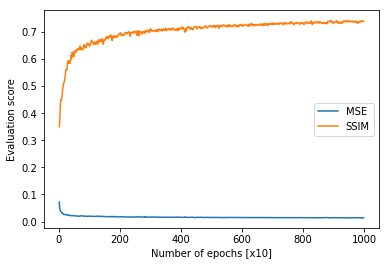

In [4]:
from itertools import zip_longest
s=xx[1].str.strip("()").str.split(',')
lol=pd.DataFrame.from_records(zip_longest(*s.values)).T
lol.columns = ['MSE', 'SSIM']
lol=lol.astype('float')
lol.rolling(3).mean().plot()
#plt.plot([0, 1000], [0.49,0.49], 'k-', lw=1)
plt.xlabel('Number of epochs [x10]')
plt.ylabel('Evaluation score')

In [7]:
folder = 'experiments/20190124-094602/W_GP_CCGAN(learn_rate=0.0001,_beta_1=0.9,_**config)/'

In [8]:
ddd = pd.read_csv(folder + 'd_loss.csv', header=None)
ggg = pd.read_csv(folder + 'g_loss.csv', header=None)

Text(0, 0.5, 'Loss')

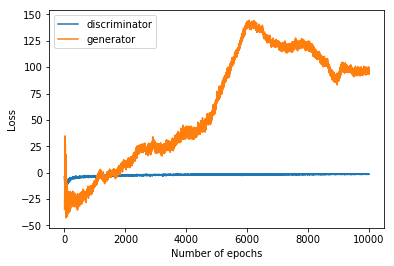

In [9]:
plt.plot(ddd.values[4::, 0], ddd.values[4::, 1], label = 'discriminator')
plt.plot(ggg.values[4::, 0], ggg.values[4::, 1], label = 'generator')

plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
#plt.plot(ggg.values[5::, 0], vv[5::])
#plt.show()
#plt.savefig(folder + 'critic_loss.png')

In [ ]:
len(ggg.values[:, 0])

In [ ]:
vv = (np.ones(1500)*0.26)

In [ ]:
(ggg.values[5::, 1])

In [ ]:
#############################################
#########  TEST ON LESIONS   ################
#############################################

In [186]:
X = np.load('data/slike/healthy-axis2-affine_transf_x_train.npy')
#X_train, X_test = train_test_split(X)

In [187]:
np.shape(X_train)

(3099, 176, 144)

In [188]:
np.shape(X_test)

(1033, 176, 144)

In [203]:
ori = X[0:5]

In [204]:
lesion = np.load('data/slike/clinical-ms-slice100-lessions.npy')
lesion = lesion[0:5]

In [205]:
def dilate(img):
    img = 1-img
    img = scipy.ndimage.morphology.binary_dilation(img, iterations=1).astype(img.dtype)
    return 1-img

In [206]:
lesion_dilate = [dilate(img) for img in lesion]

In [207]:
from copy import deepcopy
masked = deepcopy(ori)

In [208]:
for img,mask in zip(masked,lesion_dilate):
    img[mask==0] = 0

In [209]:
masked_high_dim = np.expand_dims(masked, axis=3)

In [210]:
loaded = W_GP_CCGAN.load_model('experiments/20190124-094602/W_GP_CCGAN(learn_rate=0.0001,_beta_1=0.9,_**config)/', 176, 144, 0.001, 0.9)

In [211]:
predicted_imgs = loaded.generator.predict_on_batch(masked_high_dim)

In [212]:
np.shape(predicted_imgs)

(5, 176, 144, 1)

In [213]:
predicted_imgs = (np.squeeze(predicted_imgs))

In [214]:
np.shape(predicted_imgs)

(5, 176, 144)

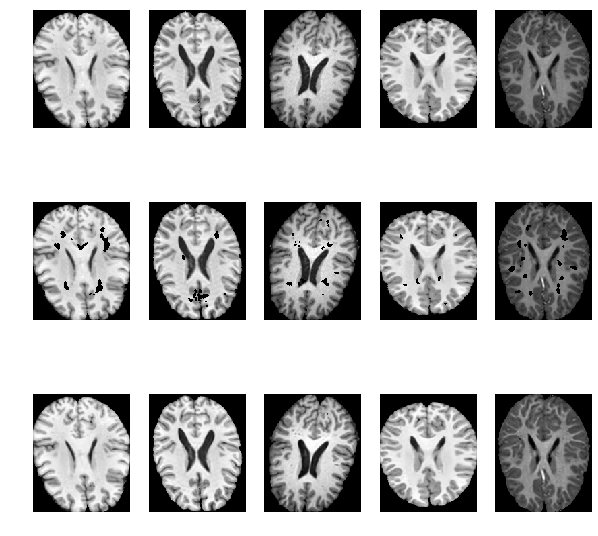

In [215]:
fig, axes = plt.subplots(3,5, figsize = (10,10))
for i, j in enumerate([0,1,2,3,4]):
    axes[0,i].imshow(ori[j], cmap = 'gray')
    axes[0,i].axis('off')
    axes[1,i].imshow(masked[j], cmap = 'gray')
    axes[1,i].axis('off')
    axes[2,i].imshow(predicted_imgs[j], cmap = 'gray')
    axes[2,i].axis('off')

In [216]:
pred = predicted_imgs[0]
m = masked[0]
o = ori[0]
ppred = predicted_imgs[1]
mm = masked[1]
oo = ori[1]

(-0.5, 19.5, 19.5, -0.5)

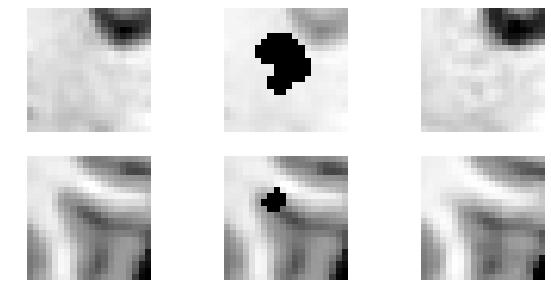

In [222]:
fig, axes = plt.subplots(2,3, figsize = (10,5))
axes[0,0].imshow(o[40:60,35:55], cmap='gray')
axes[0,0].axis('off')
axes[0,1].imshow(m[40:60,35:55], cmap='gray')
axes[0,1].axis('off')
axes[0,2].imshow(pred[40:60,35:55], cmap='gray')
axes[0,2].axis('off')
axes[1,0].imshow(oo[130:150,105:125], cmap='gray')
axes[1,0].axis('off')
axes[1,1].imshow(mm[130:150,105:125], cmap='gray')
axes[1,1].axis('off')
axes[1,2].imshow(ppred[130:150,105:125], cmap='gray')
axes[1,2].axis('off')

In [178]:
pred = predicted_imgs[1]
m = masked[1]
o = ori[1]

(-0.5, 19.5, 19.5, -0.5)

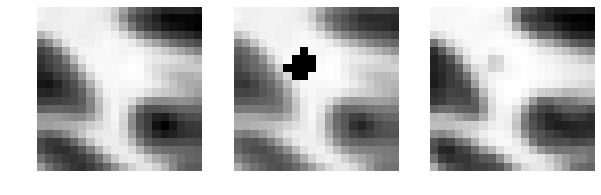

In [185]:
fig, axes = plt.subplots(1,3, figsize = (10,10))
axes[0].imshow(o[130:150,105:125], cmap='gray')
axes[0].axis('off')
axes[1].imshow(m[130:150,105:125], cmap='gray')
axes[1].axis('off')
axes[2].imshow(pred[130:150,105:125], cmap='gray')
axes[2].axis('off')

In [133]:
print(np.shape(ori))
print(np.shape(predicted_imgs))
print(np.shape(lesion_dilate))

(50, 176, 144)
(50, 176, 144)
(50, 176, 144)


In [152]:
for img_true,img_predict,mask in zip(ori,predicted_imgs, lesion_dilate):
    if mask.all() != 1:
        print(mean_squared_error(img_true[mask==0], img_predict[mask==0]))

0.0038727873802505987
0.009834676344491722
0.012446243215675435
0.01674227738403763
0.005044134504159506
0.006225361456244062
0.006090254861919307
0.00770017711576898
0.005276464879712675
0.007981142472533339
0.013288397894190021
0.007971541116415234
0.003594667707560219
0.00646840670853437
0.00542082411845209
0.0035056713817944907
0.00841918147968804
0.004398300105139483
0.011525083008970004
0.007721137443486591
0.018614814516985878
0.005530807022807246
0.0074143892920111865
0.003750947410614539
0.005147014072337145
0.014168005839200238
0.0044395362810573285
0.0036858664298951268
0.0029643980323530083
0.0068132157410822165
0.004617844086921427
0.007282292286061146
0.005779261363594629
0.0065927758997067635
0.004314700148578876
0.005487628765084839
0.005078004710851003
0.014533535422383908
0.004847046994477965
0.006927245435104259
0.0026732956324126453
0.012121820029078818
0.002908862092979793
0.005627298295082042
0.0025308020730266754
0.0007460977407779902
0.004012052721974992
0.00763

In [158]:
print('Masked area, MSE, SSIM:')
print(np.average([mean_squared_error(img_true[mask==0], img_predict[mask==0]) for img_true,img_predict,mask in zip(ori,predicted_imgs, lesion_dilate) if mask.all() != 1]))
print(np.average([compare_ssim(img_true[mask==0], img_predict[mask==0]) for img_true, img_predict, mask in zip(ori,predicted_imgs, lesion_dilate) if mask.all() != 1]))

Masked area, MSE, SSIM:
0.007001510135517912
0.7954821486345519


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


In [159]:
print('Whole image, MSE, SSIM:')
print(np.average([mean_squared_error(img_true[...,0], img_predict[...,0]) for img_true,img_predict in zip(ori, predicted_imgs)]))
print(np.average([compare_ssim(img_true[...,0], img_predict[...,0]) for img_true,img_predict in zip(ori, predicted_imgs)]))

Whole image, MSE, SSIM:
0.0008069815104775578
0.9557422400230681


/opt/conda/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:149: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


def evaluate(self, X_low_dim, scorers, epochs):
    X = np.expand_dims(X_low_dim, axis=3)
    X_train, X_test = train_test_split(X)
    start_time = time.clock()
    idx = np.random.randint(0, X_train.shape[0], 6)
    imgs = X_train[idx]
    self.sample_images(imgs,self.folder_name())
    self.save_model(self.folder_name())

    score = {scorer.__name__ : scorer(self, X_test) for scorer in scorers}
    print(time.clock() - start_time, "seconds")
    return score
results = {model:evaluate(model,X_train, scorers=scorers, epochs=epochs) for model in models}
#results = {model: 5 for model in models}
#pprint("Score on test set per parameter setting")
#pprint(results)

In [ ]:
import shutil
#shutil.rmtree('experiments/20190123-1')